# Multi-Factor Investing 
Analysis of Fama and French 5 Faktor Model with Momentum on EUROSTOXX50

In [3]:
import pandas as pd
import numpy as np
import requests
import json
from PIL import Image
from lxml import etree
import sqlite3
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import seaborn as sns
import warnings
from scipy import stats
from bs4 import BeautifulSoup
import os
import mplfinance as mpf
from datetime import datetime, timedelta
warnings.simplefilter(action='ignore',category=FutureWarning)

### 1) Data Import

##### 1.1) EUROSTOXX data

###### https://www.finanzen.net/index/euro_stoxx_50/historisch

In [4]:
# Read the CSV file
eustx = pd.read_csv("EUROSTOXX50.csv", sep=";", decimal=",")
eustx['Date'] = pd.to_datetime(eustx['Date'], format='%d.%m.%y')
eustx.head()

,Date,Close,Open,Daily_high,Daily_low
0,2024-11-01,"4.877,75","4.829,48","4.889,49","4.829,48"
1,2024-10-31,"4.827,63","4.866,03","4.866,03","4.805,23"
2,2024-10-30,"4.885,75","4.931,32","4.931,32","4.866,59"
3,2024-10-29,"4.950,02","4.978,73","4.999,72","4.948,84"
4,2024-10-28,"4.969,83","4.962,16","4.982,74","4.932,61"


In [5]:
pd.options.mode.chained_assignment = None

# Load data 
eustx = pd.read_csv("EUROSTOXX50.csv", delimiter=";", na_values=["", "NA", "N/A", "tbd"])

# Tidy data
eustx.rename(columns={
    'Date': 'Date',
    'Close': 'Close',
    'Open': 'Open',
    'Daily_high': 'High',
    'Daily_low': 'Low'
}, inplace=True)

# Adjust dates
eustx['Date'] = pd.to_datetime(eustx['Date'], format='%d.%m.%y')
eustx.set_index('Date', inplace=True)
eustx = eustx.iloc[::-1]

# Convert object columns to numeric
numeric_columns = ['Close', 'Open', 'High', 'Low']
for col in numeric_columns:
    eustx[col] = eustx[col].str.replace('.', '').str.replace(',', '.').astype(float)

# Reset index to make Date a column again
eustx = eustx.reset_index()

# Reorder columns to ensure Date is first
columns_order = ['Date'] + numeric_columns
eustxx = eustx[columns_order]

# Print data
print(eustx.head())
print("\nColumn types:")
print(eustx.dtypes)

        Date    Close     Open     High      Low
0 2009-11-02  2762.95  2735.63  2783.01  2728.11
1 2009-11-03  2712.30  2737.31  2741.48  2693.80
2 2009-11-04  2763.29  2732.64  2773.30  2728.84
3 2009-11-05  2793.44  2737.93  2808.69  2719.22
4 2009-11-06  2794.25  2788.69  2807.08  2754.06

Column types:
Date     datetime64[ns]
Close           float64
Open            float64
High            float64
Low             float64
dtype: object


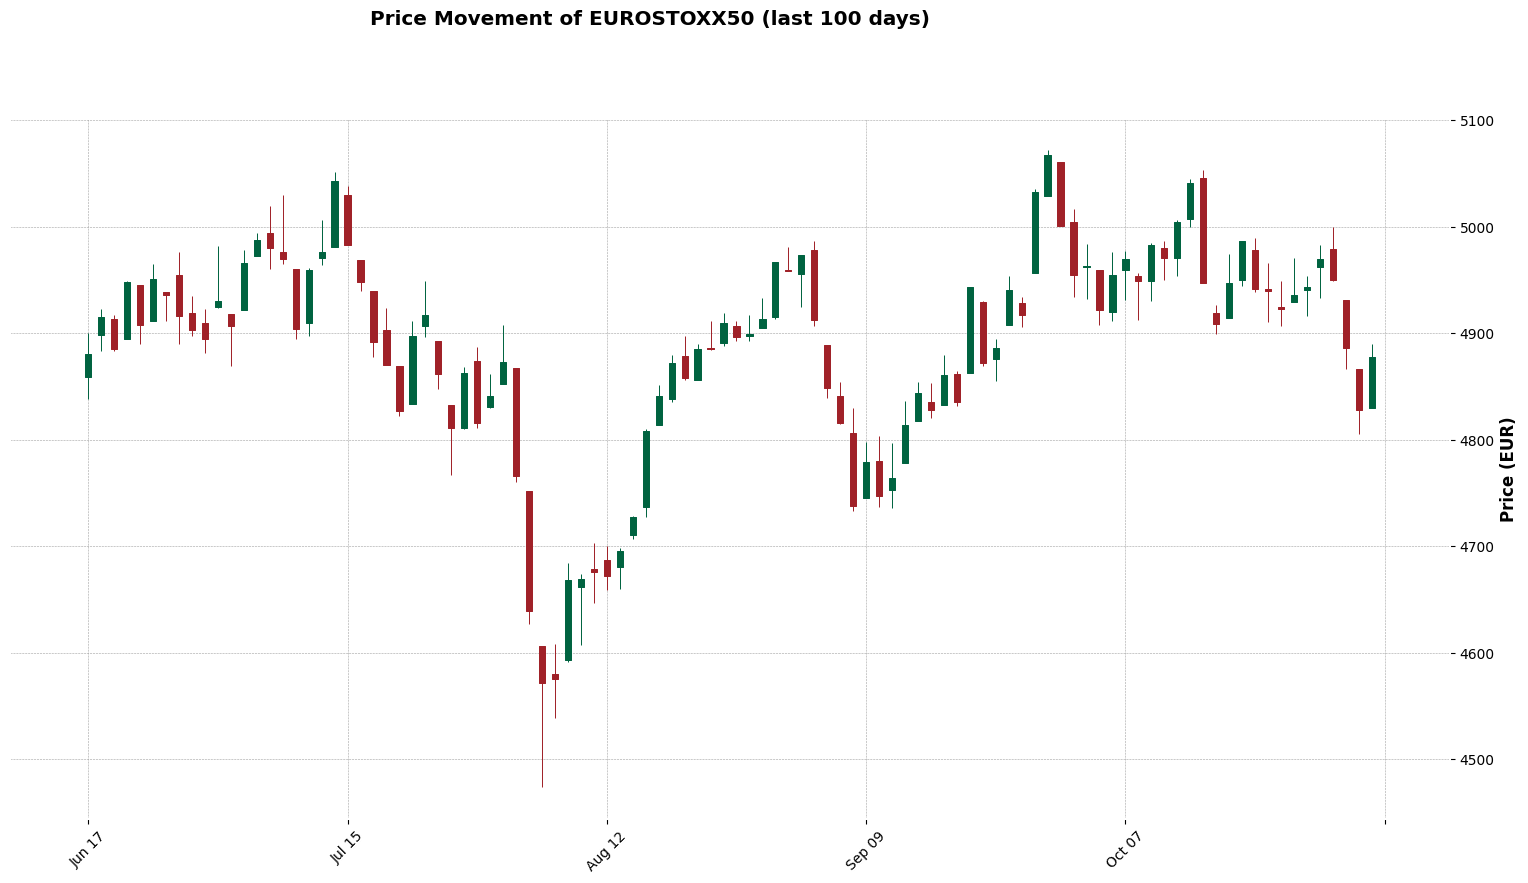

In [6]:
# Select last 100 rows of the dataframe
eustxx = eustx.tail(100)

# Ensure correct format
eustxx['Date'] = pd.to_datetime(eustxx['Date'])
eustxx.set_index('Date', inplace=True)

# Select necessary columns 
eustxx_data = eustxx[['Open', 'Close', 'High', 'Low']]

# Define figure size and scale
figsize = (20, 10) 
figscale = 1.5  

# Plot candlestick chart with adjusted figure size
mpf.plot(eustxx_data, type='candle', style='charles', title='Price Movement of EUROSTOXX50 (last 100 days)', ylabel='Price (EUR)', volume=False, figsize=figsize, figscale=figscale)

# Show plot
plt.show()

##### 1.2) Fama and French 5-factor data
15-year time window (starting from 2024-10-02)

In [7]:
ff5 = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=2, index_col=0)

# Convert the index to datetime 
ff5.index = pd.to_datetime(ff5.index, format='%Y%m%d')

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')

# Drop observations older than 2009-10-02
ff5 = ff5[ff5.index >= '2009-10-02']

# Create a new "Date" column from the index
ff5["Date"] = ff5.index

# Sort columns
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]     

# Drop index
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
print(ff5.head())

        Date  Mkt-RF   SMB   HML   RMW   CMA   RF
0 2009-10-02   -0.49 -0.31 -0.13 -0.11  0.02  0.0
1 2009-10-05    1.54  0.36  1.81 -0.34  0.38  0.0
2 2009-10-06    1.42  0.52  0.24  0.11 -0.17  0.0
3 2009-10-07    0.28 -0.30  0.58 -0.37 -0.12  0.0
4 2009-10-08    0.82  0.31  0.38  0.84  0.02  0.0


In [8]:
#Merge data
data = pd.merge(eustx, ff5, on='Date', how='inner')
len(data)

3710

##### 1.3) Momentum data

        Date    Close  Momentum
0 2009-11-02  2762.95       0.0
1 2009-11-03  2712.30       0.0
2 2009-11-04  2763.29       0.0
3 2009-11-05  2793.44       0.0
4 2009-11-06  2794.25       0.0
5 2009-11-09  2860.11       0.0
6 2009-11-10  2856.44       0.0
7 2009-11-11  2881.01       0.0
8 2009-11-12  2876.92       0.0
9 2009-11-13  2883.04       0.0

Momentum Summary Statistics:
count    3710.000000
mean        0.044646
std         0.142812
min        -0.295404
25%        -0.048974
50%         0.030402
75%         0.156160
max         0.608260
Name: Momentum, dtype: float64


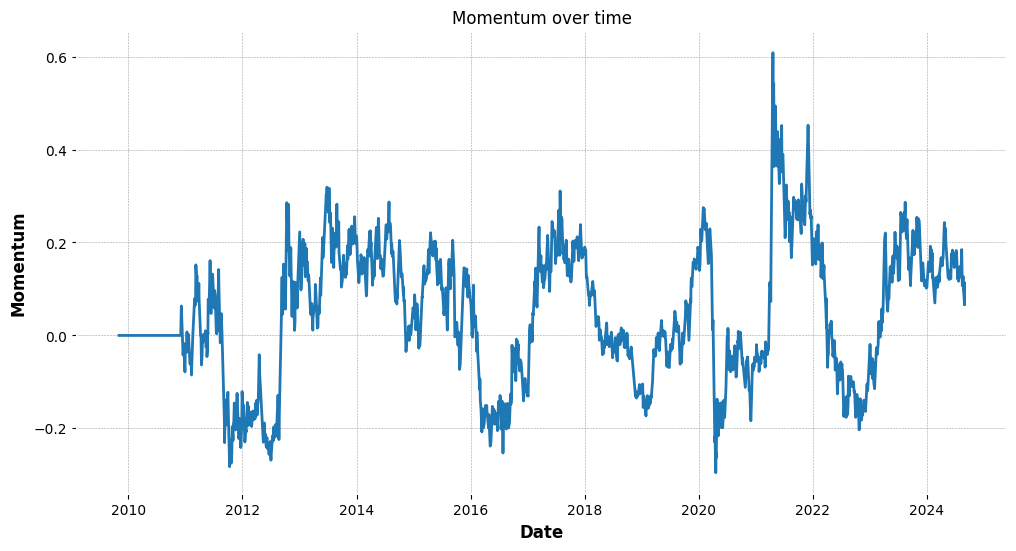

In [9]:
# Prepare the momentum factor calculated from the data
# Function to calculate momentum
def calculate_momentum(data, lookback=252, skip=21):
    return data.pct_change(lookback).shift(skip)

# Calculate momentum
data['Momentum'] = calculate_momentum(data['Close'])

# Fill NaN values in the Momentum column with 0
data['Momentum'] = data['Momentum'].fillna(0)

# Print the first few rows of the dataframe to verify
print(data[['Date', 'Close', 'Momentum']].head(10))

# Print summary statistics of the Momentum column
print("\nMomentum Summary Statistics:")
print(data['Momentum'].describe())
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Momentum'])
plt.title('Momentum over time')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.show()


### 2) Set up and run Fama and French 5-Factor Model

In [10]:
def calculate_momentum(data, lookback=252, skip=21):
    return data.pct_change(lookback).shift(skip)

def compute_excess_return_and_run_regression(data):
    try:
        # Ensure Date is in datetime format and set as index
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)

        # Calculate daily returns
        data['Daily_Return'] = data['Close'].pct_change()

        # Calculate momentum
        data['Momentum'] = calculate_momentum(data['Close'])

        # Calculate excess returns: ETF returns - Risk-free rate
        data['Excess_Return'] = data['Daily_Return'] - data['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression
        factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Momentum']

        # Check for NaN values in relevant columns after calculation
        columns_to_check = ['Excess_Return'] + factors
        if data[columns_to_check].isnull().any().any():
            print("NaN values found after calculation. Dropping rows with NaN values.")
            data.dropna(subset=columns_to_check, inplace=True)

        # Prepare X and y for regression
        X = data[factors]
        y = data['Excess_Return']
        
        X = sm.add_constant(X)  # Add constant term

        # Run OLS regression
        model = sm.OLS(y, X).fit()
        
        print("Regression results for Fama-French 5-factor model with Momentum:")
        print(model.summary())

    except Exception as e:
        print(f"Error processing data: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Run the computation and regression
compute_excess_return_and_run_regression(data)

NaN values found after calculation. Dropping rows with NaN values.
Regression results for Fama-French 5-factor model with Momentum:
                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     381.9
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:59:41   Log-Likelihood:                 11037.
No. Observations:                3437   AIC:                        -2.206e+04
Df Residuals:                    3430   BIC:                        -2.202e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]

### 3) Robustness Check

Correlation matrix as heatmap

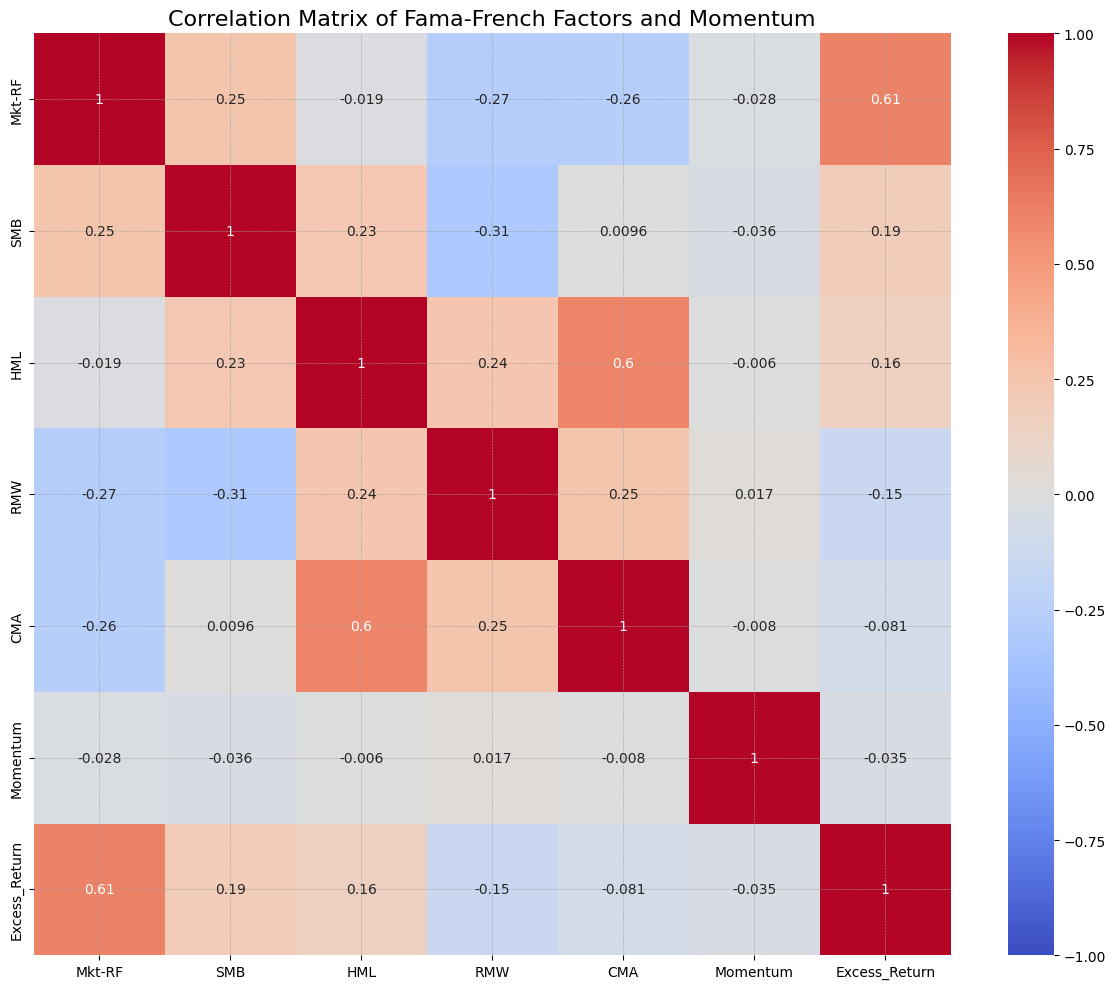


Correlation Matrix:
                 Mkt-RF       SMB       HML       RMW       CMA  Momentum  \
Mkt-RF         1.000000  0.248431 -0.018816 -0.270443 -0.261332 -0.027783   
SMB            0.248431  1.000000  0.229457 -0.313628  0.009638 -0.036196   
HML           -0.018816  0.229457  1.000000  0.239319  0.596586 -0.006027   
RMW           -0.270443 -0.313628  0.239319  1.000000  0.247712  0.016518   
CMA           -0.261332  0.009638  0.596586  0.247712  1.000000 -0.008019   
Momentum      -0.027783 -0.036196 -0.006027  0.016518 -0.008019  1.000000   
Excess_Return  0.609169  0.190660  0.155187 -0.147533 -0.081119 -0.034817   

               Excess_Return  
Mkt-RF              0.609169  
SMB                 0.190660  
HML                 0.155187  
RMW                -0.147533  
CMA                -0.081119  
Momentum           -0.034817  
Excess_Return       1.000000  

Highly correlated factors (|correlation| > 0.5):
Mkt-RF and Excess_Return: 0.61
HML and CMA: 0.60


In [11]:
def create_correlation_heatmap(data):
    # Select the factors for correlation analysis
    factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Momentum', 'Excess_Return']
    
    # Create a correlation matrix
    corr_matrix = data[factors].corr()
    
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))
    
    # Create a heatmap using seaborn
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    
    # Set the title
    plt.title('Correlation Matrix of Fama-French Factors and Momentum', fontsize=16)
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
    # Print the correlation matrix
    print("\nCorrelation Matrix:")
    print(corr_matrix)
    
    # Identify highly correlated factors
    print("\nHighly correlated factors (|correlation| > 0.5):")
    for i in range(len(factors)):
        for j in range(i+1, len(factors)):
            if abs(corr_matrix.iloc[i, j]) > 0.5:
                print(f"{factors[i]} and {factors[j]}: {corr_matrix.iloc[i, j]:.2f}")

# Assuming 'data' is your DataFrame with all the necessary data
# Make sure you have calculated 'Momentum' and 'Excess_Return' as in the previous code

# Call the function
create_correlation_heatmap(data)